# NI-VSM 2.DÚ
---
Jan Peřina  & Zdena Tropková & Matěj Hoffmann

---

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import scipy

pd.options.plotting.backend = "plotly"
pd.options.display.max_columns = 30

In [2]:
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
K = 30
L = len("Perina")
X = 1 + (K*L*23 % 20)
Y = (X + ((K*5 + L*7) % 19) % 20) + 1
xxx = f'{X:03d}.txt'
yyy = f'{Y:03d}.txt'
print(f"Budou použity soubory {xxx} a {yyy}")

Budou použity soubory 001.txt a 004.txt


## Načtení souborů, spočítání a vizualizace pravděpodobností

In [4]:
with open(f'../data/{xxx}', 'r') as f:
    f.readline()  # nadpis ignorujeme
    first = f.read()
    print(f'Délka prvního textu: {len(first)}')

with open(f'../data/{yyy}', 'r') as f:
    f.readline()
    second = f.read()
    print(f'Délka druhého textu: {len(second)}')

Délka prvního textu: 6458
Délka druhého textu: 5607


# Střední hodnota a rozptyl délek slov v textech

In [5]:
def preprocess_text(text):
    '''
    function to process text into statistics df
    '''
    df = pd.DataFrame(data=text.split())
    df.columns = ['words']
    df = df.groupby(by='words').size().rename('occurences').reset_index().sort_values(by='occurences', ascending=False)
    df['length'] = df['words'].apply(len)
    return df

In [6]:
first_df = preprocess_text(first)
second_df = preprocess_text(second)

In [7]:
print(f'První text \nstřední hodnota: {first_df.length.mean():.3f} \nvariance: {first_df.length.var():.3f} \npočet slov: {first_df["occurences"].sum()}')

První text 
střední hodnota: 5.600 
variance: 4.377 
počet slov: 1200


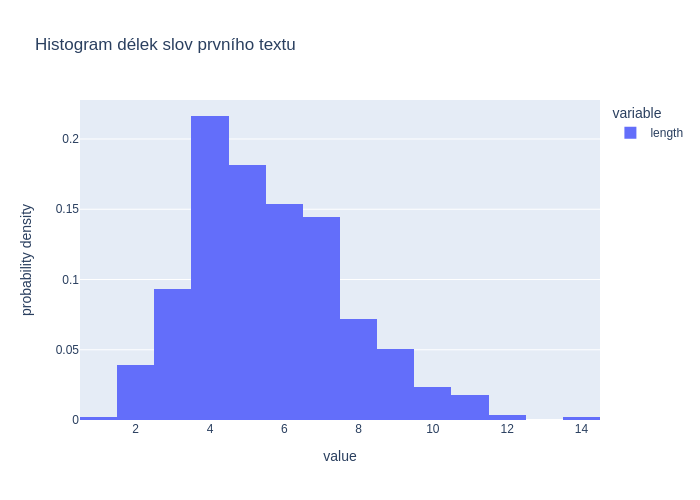

In [8]:
first_df['length'].plot(kind='hist', title=f'Histogram délek slov prvního textu', histnorm='probability density')

První text obsahuje slova v průměru 5.6 znaků dlouhé, nejčastější délka slova byla (viz histogram) 4. V histogramu se nachází jeden outlier o velikosti 14 znaků.

In [9]:
print(f'Druhý text \nstřední hodnota: {second_df.length.mean():.3f} \nvariance: {second_df.length.var():.3f} \npočet slov: {second_df["occurences"].sum()}')

Druhý text 
střední hodnota: 5.911 
variance: 6.155 
počet slov: 1030


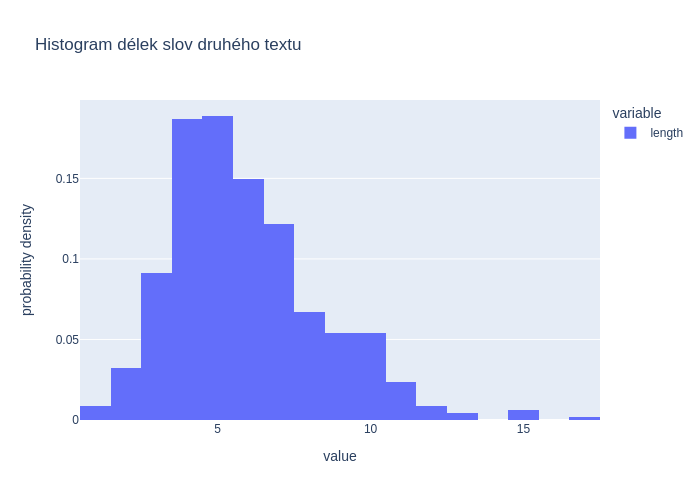

In [10]:
second_df['length'].plot(kind='hist', title=f'Histogram délek slov druhého textu', histnorm='probability density')


U druhého textu je výběrová střední hodnota 5.911, což je ve stejném binu, jako nejčastější hodnota. U druhého textu je větší výběrový rozptyl a dokonce obsahuje slovo délky 17 znaků. 

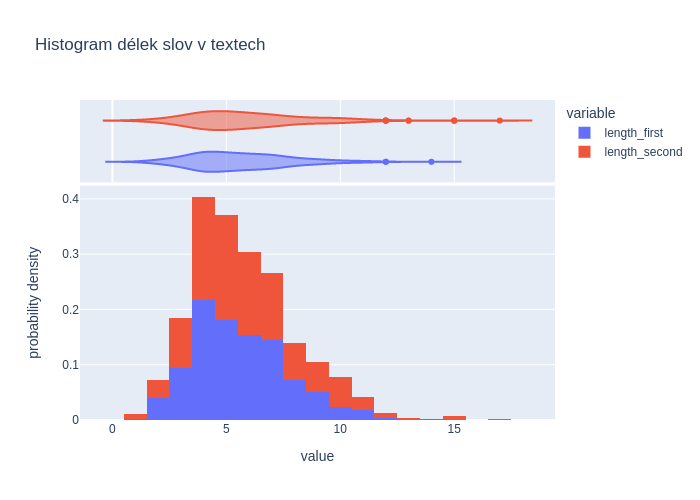

In [11]:
first_df.set_index('words').join(second_df.set_index('words'), how='outer',lsuffix='_first', rsuffix='_second')[['length_first', 'length_second']]\
    .plot(kind='hist', marginal="violin", title="Histogram délek slov v textech", histnorm='probability density')


Při srovnání obou histogramů je vidět, že jsou si podobné, ale první text vytváří `"menší kopec"`. V druhém textu se taktéž nachází více odlehlých hodnot.

---

# Odhady pravděpodobnnosti znaků
Stejně jako v minulém úkolu dojde k načtení datasetu, tentokrát však vynecháme mezery.

In [12]:
def count_letters(text):
    counts = {}

    for x in text:
        if x == ' ':
            continue

        if x not in counts:
            counts[x] = 1

        else:
            counts[x] += 1

    df = pd.DataFrame.from_dict(counts, orient='index', columns=['counts'])
    df['freq'] = df['counts'] / len(text)
    df.sort_values(by=['freq'], ascending=False, inplace=True)
    df.index = df.index.rename('znak')

    return df

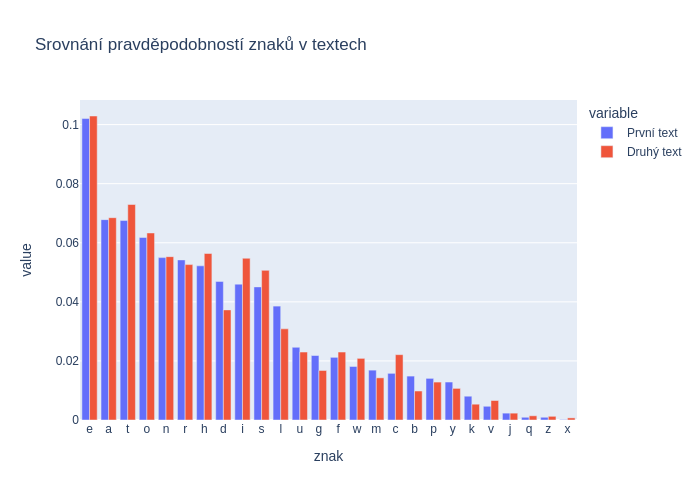

In [13]:
first_char_df = count_letters(first)
second_char_df = count_letters(second)

joined_df = first_char_df[['freq']].join(second_char_df[['freq']], lsuffix='_f', rsuffix='_s', how='outer').fillna(0)
joined_df.columns = ['První text', 'Druhý text']
joined_df.sort_values(by=['První text'], inplace=True, ascending=False)
joined_df.plot(kind='bar',title='Srovnání pravděpodobností znaků v textech ', barmode='group')

Pokud se podíváme na výsledný graf, vidíme že jsou si pravděpodobnosti jednotlivých znaků podobné.

---

# Test nezávislosti rozdělení délek slov

Z obou datasetů se slovy napočítáme četnosti jednotlivých délek slov a ty následně použijeme do $\chi^2 $ (nebo také Pearsonův-chi kvadrát)  testu s kontingenční tabulkou, kde:
Testujeme hypotézu


$$ \mathcal{H}_0:\text{Rozdělení délek slov jsou stejná.}$$ 


proti alternativě


$$ \mathcal{H}_A:\text{Existuje odlišnost v rozdělení délek slov. } $$


Testujeme na hladině $\alpha = 5\%$, čemuž odpovídá `chi2_contingency` ze `scipy`.

In [14]:
word_df = first_df.set_index('words')[['length']].value_counts().sort_index().rename('counts').to_frame()
word_df = word_df.join(second_df.set_index('words')[['length']].value_counts().sort_index().rename('counts').to_frame(), lsuffix='_l', rsuffix='_r', how='outer').fillna(0)
word_df.T

length,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17
counts_l,1.0,20.0,48.0,111.0,93.0,79.0,74.0,37.0,26.0,12.0,9.0,2.0,0.0,1.0,0.0,0.0
counts_r,4.0,15.0,42.0,86.0,87.0,69.0,56.0,31.0,25.0,25.0,11.0,4.0,2.0,0.0,3.0,1.0


Podle sestavené tabulky vidíme, že některé hodnoty mají frekvenci výskytu v daném textu menší než 5.

Po troše hledání jsme nalezli [diskuzi](https://www.researchgate.net/post/What_is_the_alternative_test_of_Chi-square_if_there_exist_many_cells_have_expected_frequency_less_than_5), kde se tímto tématem zabývají a vesměs zde vyplynula dvě řešení:
- použít [G-test](https://en.wikipedia.org/wiki/G-test), který se v praxi používá pro stejné účely jako $\chi^2$ testy. Hlavním rozdílem je, že používá metodu maximální věrohodnosti k výpočtu testové statistiky. 
- měnit tvar kontingenční tabulky (slučování hodnot)

Rozhodli jsme se jít první cestou a použít G-test. Podle stránky na Wikipedii nemá tato metoda žádná omezení.

In [15]:
from scipy.stats import chi2_contingency

In [16]:
dof = word_df.values.size  - sum(word_df.values.shape) + word_df.values.ndim-1
crit = scipy.stats.chi2.isf(0.05, dof)

In [17]:
chi2, p_value, dof, _ = chi2_contingency(word_df.T.values, lambda_="log-likelihood")

In [18]:
print(f"Stupně volnosti: {dof}")
print(f"Testová statistika: {chi2}")
print(f"Kritický obor: {crit}")
print(f"p-hodnota: {p_value}")

Stupně volnosti: 15
Testová statistika: 22.62491709788893
Kritický obor: 24.99579013972863
p-hodnota: 0.09243477285306816


In [19]:
p_value < 0.05 

False

In [20]:
chi2 > crit

False

Jelikož testová statistika není z oboru kritických hodnot a taktéž p-hodnota není menší než hladina významnosti 5%.

**Nezamítáme** hypotézu $ \mathcal{H}_0$, že rozdělení délek slov jsou stejná. 

---

# Test shody středních hodnot délek slov

Jako další otestujeme 


$$ \mathcal{H}_0: \text{Střední hodnoty délek slov v textech se rovnají.}$$ 


proti alternativě


$$ \mathcal{H}_A: \text{Střední hodnoty délek slov v textech se nerovnají. } $$

Za pomoci `dvouvýběrového t-testu` s neznámým rozptylem.

Testujeme na hladině významnosti $\alpha = 5\%$, k čemuž použijeme párový ttest.

In [21]:
# výběrové střední hodnoty
first_df.length.mean(), second_df.length.mean()

(5.6003898635477585, 5.911062906724512)

In [22]:
from scipy.stats import ttest_ind

In [23]:
var1N1 = first_df['length'].var() / first_df['length'].shape[0]
var2N2 = second_df['length'].var() / second_df['length'].shape[0]
dof = (var1N1 + var2N2)**2
dof /= (((var1N1**2) / (first_df['length'].shape[0] - 1)) + ((var2N2**2) / (second_df['length'].shape[0] - 1)))
# https://www.itl.nist.gov/div898/handbook/eda/section3/eda353.htm

In [24]:
T, p_value = ttest_ind(first_df['length'], second_df['length'], equal_var=False,)
crit = scipy.stats.t.isf(0.05 / 2, dof)

In [25]:
print(f"Testová statistika: {T}")
print(f"Kritický obor: {crit}")
print(f"p-hodnota: {p_value}")

Testová statistika: -2.1000992924848316
Kritický obor: 1.962591427360798
p-hodnota: 0.03599666942000182


In [26]:
abs(T) >= crit

True

In [27]:
p_value < 0.05

True

Testová statistika je z oboru kritických hodnot, taktéž p-hodnota je menší, než hladina významnosti 5%.

**Zamítáme** hypotézu $ \mathcal{H}_0$, že rozdělení délek slov jsou stejná, ve prospěch alternativní hypotézy $ \mathcal{H}_A$, že se nerovnají.

$\mathcal{H}_A$ je statisticky významná. 

---

# Test nezávislosti rozdělení znaků

Jako poslední testujeme hypotézu


$$ \mathcal{H}_0:\text{Rozdělení písmen jsou stejná.}$$ 


proti alternativě


$$ \mathcal{H}_A:\text{Existuje odlišnost v rozdělení písmen. } $$

K tomu použijeme $ \chi^2$` test s kontingenční tabulkou`. 

Testujeme na hladině významnosti $\alpha = 5\%$

In [28]:
joined_df2 = first_char_df[['counts']].join(second_char_df[['counts']], lsuffix='_f', rsuffix='_s', how='outer').fillna(0)
joined_df2.columns = ['První text', 'Druhý text']
joined_df2.sort_values(by=['První text'], inplace=True, ascending=False)
joined_df2.T

znak,e,a,t,o,n,r,h,d,i,s,l,u,g,f,w,m,c,b,p,y,k,v,j,q,z,x
První text,659,438,436,399,355,350,337,303,297,291,249,159,141,137,117,109,102,96,91,83,52,30,15,6,6,1
Druhý text,577,384,409,355,310,295,316,209,307,284,173,129,94,129,117,80,124,55,72,60,30,37,13,8,7,4


Z tabulky si můžeme všimnout, že znak `x` má četnost menší než 5 u obou textů, což ale není problém, jelikož je zde tolerance pro takové případy a to max 20%.

In [29]:
dof = joined_df2.values.size  - sum(joined_df2.values.shape) + joined_df2.values.ndim-1

In [30]:
chi2, p_value, dof, _ = chi2_contingency(joined_df2.values, correction=False)

In [31]:
print(f"Stupně volnosti: {dof}")
print(f"Testová statistika: {chi2}")
print(f"Kritický obor: {scipy.stats.chi2.isf(0.05, dof)}")
print(f"p-hodnota: {p_value}")

Stupně volnosti: 25
Testová statistika: 50.46409057419812
Kritický obor: 37.65248413348277
p-hodnota: 0.0018673351035501215


In [32]:
p_value < 0.05

True

In [33]:
chi2 > crit

True

Testová statistika je z oboru kritických hodnot, taktéž p-hodnota je menší, než hladina významnosti 5%.

**Zamítáme** hypotézu $ \mathcal{H}_0$, že rozdělení písmen jsou stejná, ve prospěch alternativní hypotézy $ \mathcal{H}_A$, že se nerovnají.

$\mathcal{H}_A$ je statisticky významná. 
